In [4]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
pip install wordcloud

In [5]:
df = pd.read_csv("Tweets.csv")

In [6]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
airlines = df['airline'].unique()

print("Airlines:", airlines)

Airlines: ['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']


In [8]:
def get_airline_sentiment(df, airlines):
    positives = []
    negatives = []
    neutrals = []

    for airline in airlines:
        positive = df.query('@airline == airline and airline_sentiment == "positive"')['tweet_id'].count()
        negative = df.query('@airline == airline and airline_sentiment == "negative"')['tweet_id'].count()
        neutral = df.query('@airline == airline and airline_sentiment == "neutral"')['tweet_id'].count()
        
        positives.append(positive)
        negatives.append(negative)
        neutrals.append(neutral)
          
    return positives, negatives, neutrals
        

     
positives, negatives, neutrals = get_airline_sentiment(df, airlines)

sentiment_airlines_df = pd.DataFrame(index = airlines);
sentiment_airlines_df['neutrals'] = neutrals
sentiment_airlines_df['positives'] = positives
sentiment_airlines_df['negatives'] = negatives
sentiment_airlines_df

,neutrals,positives,negatives
Virgin America,171,152,181
United,697,492,2633
Southwest,664,570,1186
Delta,723,544,955
US Airways,381,269,2263
American,463,336,1960


In [9]:
sentiment_airlines_percentage_df = pd.DataFrame(index = airlines);
sentiment_airlines_percentage_df['neutrals (%)'] = list(map(lambda n: n / sum(neutrals) * 100, neutrals))
sentiment_airlines_percentage_df['positives (%)'] = list(map(lambda n: n / sum(positives) * 100, positives))
sentiment_airlines_percentage_df['negatives (%)'] = list(map(lambda n: n / sum(negatives) * 100, negatives))
sentiment_airlines_percentage_df

,neutrals (%),positives (%),negatives (%)
Virgin America,5.517909,6.432501,1.972107
United,22.491126,20.820990,28.688167
Southwest,21.426267,24.121879,12.922205
Delta,23.330106,23.021583,10.405317
US Airways,12.294288,11.383834,24.656788
American,14.940303,14.219213,21.355415


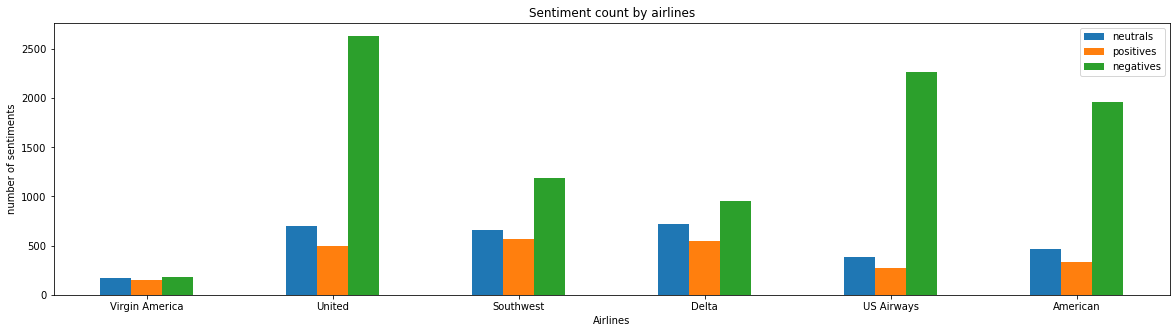

In [10]:
sentiment_airlines_df.plot.bar(rot=0, figsize=(20,5))

plt.title('Sentiment count by airlines')
plt.xlabel('Airlines')
plt.ylabel('number of sentiments')

plt.show()

In [11]:
sentiment_df = df[['airline_sentiment', 'text']].copy()

In [12]:
sentiment_df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<AxesSubplot:>

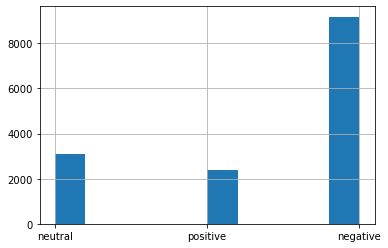

In [13]:
sentiment_df['airline_sentiment'].hist()

In [14]:
sentiment_encode = {
    'negative': 0, 
    'positive': 1, 
    'neutral': 2
}

In [15]:
sentiment_df['encoded_sentiment'] = sentiment_df['airline_sentiment'].map(sentiment_encode)

sentiment_df.head()

,airline_sentiment,text,encoded_sentiment
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [16]:
df_train, df_test = train_test_split(sentiment_df, train_size = 0.30)

print(f'Number of train samples are: {len(df_train.index)}.\nNumber of test samles are: {len(df_test.index)}.')

Number of train samples are: 4392.
Number of test samles are: 10248.


In [17]:
df_train.tail()

,airline_sentiment,text,encoded_sentiment
9659,negative,@USAirways is the worst airline to ever travel...,0
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3519,negative,@united loses my luggage and @hotelstonight lo...,0
14163,negative,@AmericanAir if this is how you guys work then...,0
12877,negative,@AmericanAir not only on both legs did I have ...,0


In [18]:
df_test.tail()

,airline_sentiment,text,encoded_sentiment
14421,negative,"@AmericanAir Flt Cancelled Flighted, reschedul...",0
9728,negative,@USAirways What is with your lost &amp; found....,0
671,negative,@united I'm grounded in Montreal with ua3659. ...,0
13701,negative,@AmericanAir Yes and without my bags. 2 first ...,0
4043,negative,@united is amazing how hard is to talk with cu...,0


In [19]:
vectorizer = TfidfVectorizer(max_features = 2000)
vectorizer

TfidfVectorizer(max_features=2000)

In [20]:
X_train = vectorizer.fit_transform(df_train['text'])
X_train

<4392x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 63868 stored elements in Compressed Sparse Row format>

In [21]:
X_test = vectorizer.transform(df_test['text'])
X_test

<10248x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 144837 stored elements in Compressed Sparse Row format>

In [22]:
Y_train = df_train['encoded_sentiment']
Y_test = df_test['encoded_sentiment']

In [23]:
df_train

,airline_sentiment,text,encoded_sentiment
11076,neutral,@USAirways would like to see you do similar in...,2
12269,negative,@AmericanAir Lost and Found is like talking to...,0
10882,negative,"@USAirways get ur act together, start treating...",0
9787,negative,@USAirways so you don't have a pilot now for #...,0
8548,negative,@JetBlue PR-friendly tweets don't help drive a...,0
...,...,...,...
9659,negative,@USAirways is the worst airline to ever travel...,0
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3519,negative,@united loses my luggage and @hotelstonight lo...,0
14163,negative,@AmericanAir if this is how you guys work then...,0


In [24]:
df_test

,airline_sentiment,text,encoded_sentiment
10657,negative,"@USAirways It says to call. Before connecting,...",0
13083,negative,@AmericanAir @maxfitgirl29 next time fly South...,0
13518,negative,“@AmericanAir: @mwangbickler We apologize for ...,0
6979,positive,@JetBlue Thanks so much for talking to me! The...,1
13817,negative,"@AmericanAir today, after 6 yrs., no longer my...",0
...,...,...,...
14421,negative,"@AmericanAir Flt Cancelled Flighted, reschedul...",0
9728,negative,@USAirways What is with your lost &amp; found....,0
671,negative,@united I'm grounded in Montreal with ua3659. ...,0
13701,negative,@AmericanAir Yes and without my bags. 2 first ...,0


### Build a logistic reggression instace ###

In [25]:
model = LogisticRegression(max_iter = 500)

In [26]:
model.fit(X_train, Y_train)

LogisticRegression(max_iter=500)

In [27]:
print("Train acc:", model.score(X_train, Y_train))

Train acc: 0.8615664845173042


In [28]:
print("Test acc:", model.score(X_test, Y_test))

Test acc: 0.7820062451209993


In [32]:
P_train = model.predict(X_train)
P_test = model.predict(X_test)

In [33]:
cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

array([[0.97800587, 0.00549853, 0.0164956 ],
       [0.2090784 , 0.71251719, 0.0784044 ],
       [0.32230523, 0.03948773, 0.63820704]])

In [34]:
classes = ['negative', 'positive', 'neutral'] 

Text(33.0, 0.5, 'Target')

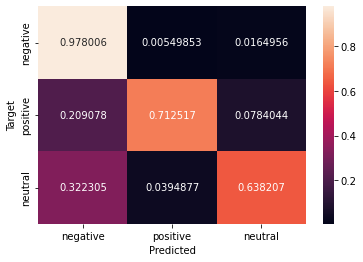

In [35]:
df_cm = pd.DataFrame(cm, index=classes,columns=classes)

ax = sn.heatmap(df_cm, annot=True, fmt='g')
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

In [36]:
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
cm_test

array([[0.94418605, 0.01410853, 0.04170543],
       [0.30806846, 0.55440098, 0.13753056],
       [0.45929695, 0.07030527, 0.47039778]])

Text(33.0, 0.5, 'Target')

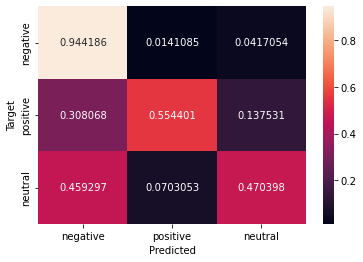

In [37]:
df_cm = pd.DataFrame(cm_test, index=classes, columns=classes)

ax = sn.heatmap(df_cm, annot=True, fmt='g')
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")